In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from typing import Tuple, List, Dict

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, cross_validate

# permutation importance
from sklearn.inspection import permutation_importance

import category_encoders as ce


# read data
in_kaggle = False


def get_data_file_path(is_in_kaggle: bool) -> Tuple[str, str, str]:
    train_path = ''
    test_path = ''
    sample_submission_path = ''

    if is_in_kaggle:
        # running in Kaggle, inside the competition
        train_path = '../input/tabular-playground-series-feb-2021/train.csv'
        test_path = '../input/tabular-playground-series-feb-2021/test.csv'
        sample_submission_path = '../input/tabular-playground-series-jan-2021/sample_submission.csv'
    else:
        # running locally
        train_path = 'data/train.csv'
        test_path = 'data/test.csv'
        sample_submission_path = 'data/sample_submission.csv'

    return train_path, test_path, sample_submission_path

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred) ** 0.5

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# fix skewness via abs sqrt transform
def sqrt_abs_transform(df: pd.DataFrame) -> pd.DataFrame:

    for c in df.select_dtypes(include = [np.number]).columns:
        df[c] = df[c].abs() ** 0.5
    
    return df

# fix skewness via log transform
def log_transform_numeric_cols(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    for c in df.select_dtypes(include = [np.number]).columns:
        df[c] = np.log(df[c].values+1)
    return df

# reverse log transform
def exp_transform_numeric_cols(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    for c in df.select_dtypes(include = [np.number]).columns:
        df[c] = np.exp(df[c].values)-1
    return df

In [3]:
# main flow
start_time = dt.datetime.now()
print("Started at ", start_time)

Started at  2021-02-13 19:29:32.144923


In [4]:
%%time
# get the training set and labels
train_set_path, test_set_path, sample_subm_path = get_data_file_path(in_kaggle)

df_train = pd.read_csv(train_set_path)
df_test = pd.read_csv(test_set_path)

subm = pd.read_csv(sample_subm_path)

Wall time: 1.8 s


In [5]:
df_train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,A,B,A,A,B,D,A,E,C,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
1,2,B,A,A,A,B,B,A,E,A,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
2,3,A,A,A,C,B,D,A,B,C,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
3,4,A,A,A,C,B,D,A,E,G,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
4,6,A,B,A,A,B,B,A,E,C,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


In [6]:
# list of basic raw numeric features
num_feature_list = [col for col in df_train.columns if col.startswith('cont')]

# list of basic raw numeric features
cat_feature_list = [col for col in df_train.columns if col.startswith('cat')]


# target labels list
target = 'target'

# drop sig_id from train and test sets
df_train = df_train.drop(['id'], axis=1, errors='ignore')
df_test = df_test.drop(['id'], axis=1, errors='ignore')


In [7]:
# OHE approach + skeweness correcting via log transform

# do additional feature engineering

encoder = ce.OneHotEncoder(cols=cat_feature_list, use_cat_names=True, return_df=True)

# Assume our loan data has been imported as df already
# and split into df_train and df_test
df_train_transformed = encoder.fit_transform(df_train)

# set a hideout fold 

y = df_train_transformed['target']
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train.drop(['target'], axis=1, errors='ignore')
X_hideout = X_hideout.drop(['target'], axis=1, errors='ignore')

X_train = log_transform_numeric_cols(X_train)
X_hideout = log_transform_numeric_cols(X_hideout)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [8]:
from sklearn.metrics import accuracy_score
import lightgbm as lgb # LightGBM Model


#Additional scklearn functions
from sklearn import metrics   
from sklearn.model_selection import cross_val_score, KFold, cross_validate


# Setting stratified kfold upon the continuous target for future use
kfolds = 5
# Setting kfold for future use
kf = KFold(kfolds, random_state=42, shuffle=True)


# set a hideout fold 

y = df_train_transformed['target']
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train_transformed, y, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train.drop(['target'], axis=1, errors='ignore')
X_hideout = X_hideout.drop(['target'], axis=1, errors='ignore')

def print_lightgbm_feature_importance(X, y, estimator):
    #Print Feature Importance:
    estimator.fit(X, y)
    predictors = X.columns

    feat_imp = pd.Series(estimator.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.nlargest(30).plot(kind='barh', title='Feature Importances', figsize=(8,10))
    plt.ylabel('Feature Importance Score')
    df = feat_imp.to_frame().reset_index()
    df = df.rename(columns={'index': 'predictor', 0: "fi_score"})
    return df


def model_check(X, y, estimator, model_name, model_description, kfs, is_y_log_transformed=False):
    model_table = pd.DataFrame()
    
    train_rmse = []
    valid_rmse = []
    hideout_rmse = []

    fitting_start_time = dt.datetime.now()
    for i, (train_index, test_index) in enumerate(kfs.split(X)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = X.iloc[train_index, :].copy(), X.iloc[test_index, :].copy()
        
        rmse = 0.0
        
        fit_model = model.fit(X_train, y_train)
        
        pred = model.predict(X_train)
        if is_y_log_transformed:
            # reverse Y to original scale
            y_train = np.exp(y_train) - 1
            pred = np.exp(pred) - 1
        rmse = RMSLE(y_train, pred)
        print('RMSLE Regressor, training set, fold ', i, ': ', rmse)
        train_rmse.append(rmse)
        
        pred = model.predict(X_valid)
        if is_y_log_transformed:
            # reverse Y to original scale
            y_valid = np.exp(y_valid) - 1
            pred = np.exp(pred) - 1
        rmse = RMSLE(y_valid, pred)
        print('RMSLE Regressor, validation set, fold ', i, ': ', rmse)
        valid_rmse.append(rmse)
        
        pred_hideout = model.predict(X_hideout)
        if is_y_log_transformed:
            # reverse Y to original scale
            y_hideout_unscaled = np.exp(y_hideout) - 1
            pred_hideout = np.exp(pred_hideout) - 1
            rmse = RMSLE(y_hideout_unscaled, pred_hideout)
        else:
            rmse = RMSLE(y_hideout, pred_hideout)
        print('RMSLE Regressor, hideout set, fold ', i, ': ', rmse)
        hideout_rmse.append(rmse)
    
    fitting_end_time = dt.datetime.now()
    fit_time = fitting_end_time - fitting_start_time
    
    train_rmse = np.array(train_rmse)
    valid_rmse = np.array(valid_rmse)
    hideout_rmse = np.array(hideout_rmse)
        
    train_rmse = round(np.mean(train_rmse, axis=0), 4)
    val_rmse = round(np.mean(valid_rmse, axis=0), 4)
    test_rmse = round(np.mean(hideout_rmse, axis=0), 4)
    test_std = round(np.std(hideout_rmse, axis=0), 4)

    attributes = {
        'model_name': model_name,
        'train_rmse': train_rmse,
        'valid_rmse': val_rmse,
        'test_rmse': test_rmse,
        'test_rmse_std': test_std,
        'fit_time': fit_time,
        'description': model_description,
    }
    
    model_table = pd.DataFrame(data=[attributes])
    return model_table

In [9]:
# initial not tuned model
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=50, 
    max_depth=-1, 
    random_state=314, 
    silent=True,  
    n_jobs=4, 
    n_estimators=100,
    colsample_bytree=0.8,
    subsample=0.8,
    learning_rate=0.1)

In [10]:
# fit the baseline model with the training data
results_df = model_check(X_train, y_train, model, 
                         "Initial model: OHE+skewness correction", 
                         "Initial baseline - OHE+log transform", kf)
display(results_df.head())

RMSLE Regressor, training set, fold  0 :  0.8251274113765356
RMSLE Regressor, validation set, fold  0 :  0.8472485494826664
RMSLE Regressor, hideout set, fold  0 :  0.8476391112059873
RMSLE Regressor, training set, fold  1 :  0.825252952410935
RMSLE Regressor, validation set, fold  1 :  0.8457247417775715
RMSLE Regressor, hideout set, fold  1 :  0.8476516846486996
RMSLE Regressor, training set, fold  2 :  0.8254631071819676
RMSLE Regressor, validation set, fold  2 :  0.8448369556979022
RMSLE Regressor, hideout set, fold  2 :  0.8471795323784472
RMSLE Regressor, training set, fold  3 :  0.8250541893362834
RMSLE Regressor, validation set, fold  3 :  0.8480480237037447
RMSLE Regressor, hideout set, fold  3 :  0.8476785731745672
RMSLE Regressor, training set, fold  4 :  0.825190157295963
RMSLE Regressor, validation set, fold  4 :  0.8464687834623479
RMSLE Regressor, hideout set, fold  4 :  0.8475358941737566


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Initial model: OHE+skewness correction,0.8252,0.8465,0.8475,0.0002,0 days 00:00:14.129873,Initial baseline - OHE+log transform


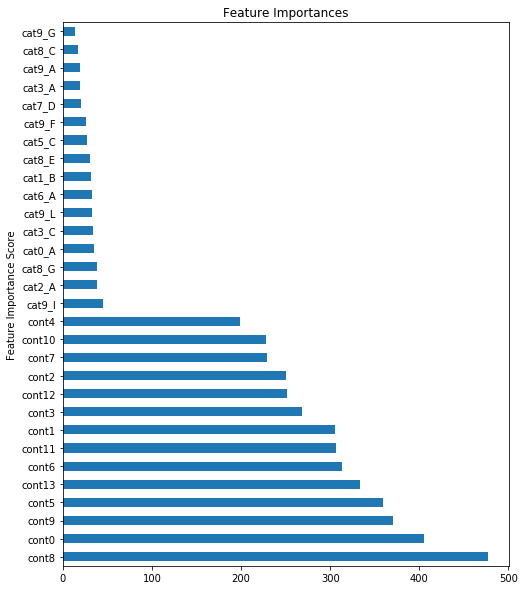

In [11]:
# output the feature importance of the baseline model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, model)

In [12]:
# do prediction on the test set, using the best model trained above
best_model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=2000, 
            min_child_samples=1600, 
            min_child_weights=0.5,
            reg_alpha=0.01,
            max_depth=-1, 
            random_state=314, 
            silent=False, 
            n_jobs=4, 
            colsample_bytree=0.7,
            subsample=0.7,
            n_estimators=3600,
            learning_rate=0.0042)


RMSLE Regressor, training set, fold  0 :  0.8251274113765356
RMSLE Regressor, validation set, fold  0 :  0.8472485494826664
RMSLE Regressor, hideout set, fold  0 :  0.8476391112059873
RMSLE Regressor, training set, fold  1 :  0.825252952410935
RMSLE Regressor, validation set, fold  1 :  0.8457247417775715
RMSLE Regressor, hideout set, fold  1 :  0.8476516846486996
RMSLE Regressor, training set, fold  2 :  0.8254631071819676
RMSLE Regressor, validation set, fold  2 :  0.8448369556979022
RMSLE Regressor, hideout set, fold  2 :  0.8471795323784472
RMSLE Regressor, training set, fold  3 :  0.8250541893362834
RMSLE Regressor, validation set, fold  3 :  0.8480480237037447
RMSLE Regressor, hideout set, fold  3 :  0.8476785731745672
RMSLE Regressor, training set, fold  4 :  0.825190157295963
RMSLE Regressor, validation set, fold  4 :  0.8464687834623479
RMSLE Regressor, hideout set, fold  4 :  0.8475358941737566


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Best model pre-trained,0.8252,0.8465,0.8475,0.0002,0 days 00:00:13.036724,"Best model, OHE+log transform"


In [22]:
# fit the best model on the full training set
y = df_train_transformed['target']
X_train = df_train_transformed.drop(['target'], axis=1, errors='ignore')

# fit the baseline model with the training data
results_df = model_check(X_train, y, best_model, 
                         "Best model pre-trained", 
                         "Best model, OHE+log transform", kf)
display(results_df.head())


RMSLE Regressor, training set, fold  0 :  0.8309763650565374
RMSLE Regressor, validation set, fold  0 :  0.8457148769565134
RMSLE Regressor, hideout set, fold  0 :  0.8418289529724647
RMSLE Regressor, training set, fold  1 :  0.8303528664540646
RMSLE Regressor, validation set, fold  1 :  0.847384453489216
RMSLE Regressor, hideout set, fold  1 :  0.8364756781918697
RMSLE Regressor, training set, fold  2 :  0.8307361517374031
RMSLE Regressor, validation set, fold  2 :  0.8462803433603213
RMSLE Regressor, hideout set, fold  2 :  0.831599388998965
RMSLE Regressor, training set, fold  3 :  0.8313050917266993
RMSLE Regressor, validation set, fold  3 :  0.8451936737344615
RMSLE Regressor, hideout set, fold  3 :  0.8317669583405563
RMSLE Regressor, training set, fold  4 :  0.8312372369979826
RMSLE Regressor, validation set, fold  4 :  0.8446301683112235
RMSLE Regressor, hideout set, fold  4 :  0.8316164726143358


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Best model pre-trained,0.8309,0.8458,0.8347,0.004,0 days 00:00:17.454731,"Best model, OHE+log transform"


In [ ]:
best_model.fit(X_train, y)

In [15]:
# preprocess the test set
df_test['target'] = 0 # for the compatibility with the encoder
df_test_transformed = encoder.transform(df_test)
df_test_transformed = df_test_transformed.drop(['target'], axis=1, errors='ignore')
df_test_transformed = log_transform_numeric_cols(df_test_transformed)


In [16]:
# predict on the test set
preds = best_model.predict(df_test_transformed)

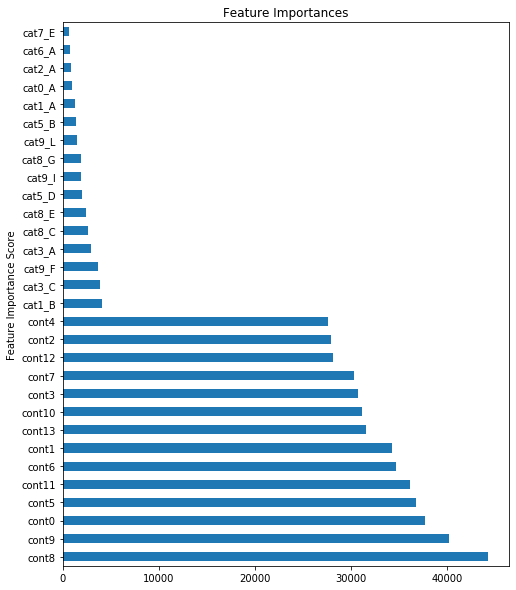

In [17]:
# output the feature importance of the best model
feat_imp = print_lightgbm_feature_importance(X_train, y, best_model)

In [18]:
# submit prediction
subm['target'] = preds
subm.to_csv("best_own_lightgbm2.csv", index=False)

# public lb score 0.87658

In [23]:
# try the model from https://www.kaggle.com/kenkpixdev/ensemble-lgb-xgb-with-hyperopt

# do prediction on the test set, using the best model trained above
tp_model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=36, 
            min_child_samples=500, 
            min_split_gain=0.2579555416739361,
            reg_alpha=0.33867231210286647,
            reg_lambda=42.071411120949854,
            max_depth=21, 
            random_state=314, 
            silent=False, 
            n_jobs=4, 
            colsample_bytree=0.6203517996970486,
            subsample=0.2595537456780356,
            n_estimators=5000,
            learning_rate=0.049019854828962754)

In [24]:
# fit the baseline model with the training data
results_df = model_check(X_train, y, tp_model, 
                         "Best model pre-trained", 
                         "Best model, OHE+log transform", kf)
display(results_df.head())

RMSLE Regressor, training set, fold  0 :  0.8309763650565374
RMSLE Regressor, validation set, fold  0 :  0.8457148769565134
RMSLE Regressor, hideout set, fold  0 :  0.8418289529724647
RMSLE Regressor, training set, fold  1 :  0.8303528664540646
RMSLE Regressor, validation set, fold  1 :  0.847384453489216
RMSLE Regressor, hideout set, fold  1 :  0.8364756781918697
RMSLE Regressor, training set, fold  2 :  0.8307361517374031
RMSLE Regressor, validation set, fold  2 :  0.8462803433603213
RMSLE Regressor, hideout set, fold  2 :  0.831599388998965
RMSLE Regressor, training set, fold  3 :  0.8313050917266993
RMSLE Regressor, validation set, fold  3 :  0.8451936737344615
RMSLE Regressor, hideout set, fold  3 :  0.8317669583405563
RMSLE Regressor, training set, fold  4 :  0.8312372369979826
RMSLE Regressor, validation set, fold  4 :  0.8446301683112235
RMSLE Regressor, hideout set, fold  4 :  0.8316164726143358


,model_name,train_rmse,valid_rmse,test_rmse,test_rmse_std,fit_time,description
0,Best model pre-trained,0.8309,0.8458,0.8347,0.004,0 days 00:00:17.613256,"Best model, OHE+log transform"


In [25]:
# fit the model, predict on the test set
tp_model.fit(X_train, y)
preds = tp_model.predict(df_test_transformed)

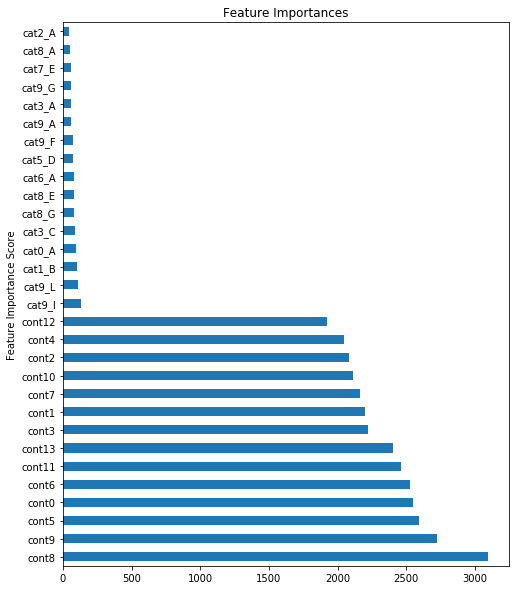

In [26]:
# output the feature importance of the best model
feat_imp = print_lightgbm_feature_importance(X_train, y, tp_model)

In [27]:
# submit prediction
subm['target'] = preds
subm.to_csv("tp_lightgbm1.csv", index=False)

In [20]:
print('We are done. That is all, folks!')
finish_time = dt.datetime.now()
print("Finished at ", finish_time)
elapsed = finish_time - start_time
print("Elapsed time: ", elapsed)

We are done. That is all, folks!
Finished at  2021-02-13 19:33:54.949825
Elapsed time:  0:04:22.804902
